## Load the required modules

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import classification_report

## Checking wheter we have a GPU or not

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Load the CIFAR 10 data

In [3]:
batch_size = 64
lr = 0.01
epoch = 20

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##Display of a few training and test images and their corresponding labels

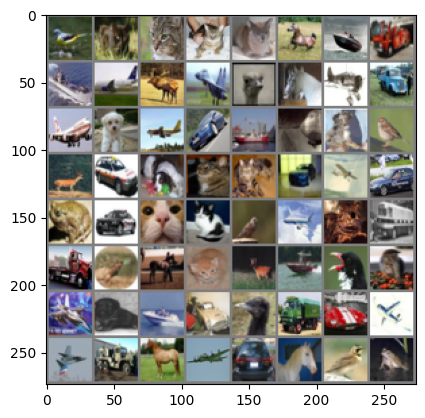

Training: bird  cat   cat   cat   cat   horse ship  truck ship  plane deer  plane bird  horse plane truck plane dog   plane car   ship  bird  dog   bird  deer  car   dog   cat   cat   car   plane car   frog  car   cat   cat   bird  plane cat   truck truck deer  horse cat   deer  ship  bird  bird  plane dog   ship  car   bird  truck car   plane plane truck horse plane car   horse bird  frog 


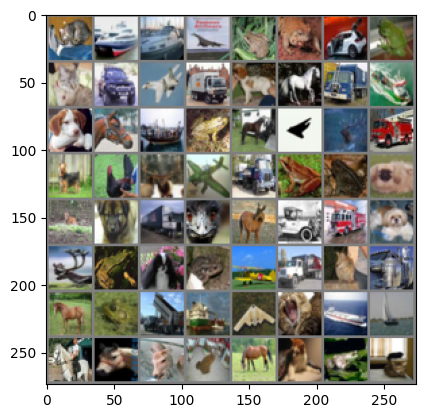

GroundTruth:  cat   ship  ship  plane


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



dataiter = iter(trainloader)
imgs_tr, labls_tr = next(dataiter)
imshow(torchvision.utils.make_grid(imgs_tr))
print('Training:', ' '.join(f'{classes[labls_tr[j]]:5s}' for j in range(batch_size)))


imgs_te, labls_te = next(iter(testloader))
imshow(torchvision.utils.make_grid(imgs_te))
print('GroundTruth: ', ' '.join(f'{classes[labls_te[j]]:5s}' for j in range(4)))

##Building the ResNet architectures

1.   Definition of the differnt blocks (e.g. Basic, Bottelneck) in a ResNet

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, identity_downsample=None):
        super(BasicBlock, self).__init__()
        self.expansion = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        out += identity
        out = self.relu(out)
        return out

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, identity_downsample=None):
        super(BottleneckBlock, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        out += identity
        out = self.relu(out)
        return out


2.   Definition of ResNet

In [6]:

class ResNet(nn.Module):
    def __init__(self, layers, image_channels, num_classes, block="BottleneckBlock"):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.block = block

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        if block == "BottleneckBlock":
            self.fc = nn.Linear(512 * 4, num_classes)
        else:
            self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        if block == "BottleneckBlock":
            if stride != 1 or self.in_channels != out_channels * 4:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_channels * 4)
                )
            layers.append(BottleneckBlock(self.in_channels, out_channels,
                                          stride, identity_downsample))
            self.in_channels = out_channels * 4

            for _ in range(num_residual_blocks - 1):
                layers.append(BottleneckBlock(self.in_channels, out_channels))
        else:
            if stride != 1 or self.in_channels != out_channels:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(out_channels)
                )
            layers.append(BasicBlock(self.in_channels, out_channels,
                                     stride, identity_downsample))
            self.in_channels = out_channels

            for _ in range(num_residual_blocks - 1):
                layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)



3.   Design of the ResNet architectures (i.e. 18, 34, 50, 101, 152)

In [7]:
def ResNet18(img_channels=3, num_classes=3):
    return ResNet(block="BasicBlock", layers=[2, 2, 2, 2],
                  image_channels=img_channels, num_classes=num_classes)

def ResNet34(img_channels=3, num_classes=3):
    return ResNet(block="BasicBlock", layers=[3, 4, 6, 3],
                  image_channels=img_channels, num_classes=num_classes)

def ResNet50(img_channels=3, num_classes=3):
    return ResNet(block="BottleneckBlock", layers=[3, 4, 6, 3],
                  image_channels=img_channels, num_classes=num_classes)

def ResNet101(img_channels=3, num_classes=3):
    return ResNet(block="BottleneckBlock", layers=[3, 4, 23, 3],
                  image_channels=img_channels, num_classes=num_classes)

def ResNet152(img_channels=3, num_classes=3):
    return ResNet(block="BottleneckBlock", layers=[3, 8, 36, 3],
                  image_channels=img_channels, num_classes=num_classes)

##Simple CNN desinged for CIFAR10

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##Training a Network (e.g., ResNet, Simple CNN)

In [11]:
num_classes = len(classes)
# model = ResNet18(img_channels=3, num_classes=num_classes).to(device)
model = SimpleCNN().to(device)
imgs, _ = next(iter(trainloader))
summary(model, (imgs.shape[1], imgs.shape[2], imgs.shape[3]))
print(f'Number of classes: {num_classes}  ----------  Names of the classes: {classes}')

optimizer_model = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()
thr = 100
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

for j in tqdm(range(epoch)):
    tr_loss = 0
    correct_train = 0
    total_train = 0
    model.train()
    for images, labels in trainloader:
        optimizer_model.zero_grad()
        outputs = model(images.to(device))
        loss = loss_func(outputs, labels.to(device))
        loss.backward()
        optimizer_model.step()
        tr_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels.to(device)).sum().item()
        if loss.data.cpu().numpy() < thr:
            torch.save(model.state_dict(), './trained_model_weights_simplecnn.pkl')
            thr = loss.data.cpu().numpy()
    training_loss.append(tr_loss / len(trainloader))
    training_accuracy.append(100 * correct_train / total_train)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images.to(device))
            loss = loss_func(outputs, labels.to(device))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels.to(device)).sum().item()
    validation_loss.append(val_loss / len(testloader))
    validation_accuracy.append(100 * correct_val / total_val)
    print(f"\nEpoch [{j+1}/{epoch}], Train Loss: {training_loss[-1]:.4f}, Val Loss: {validation_loss[-1]:.4f}, Train Acc: {training_accuracy[-1]:.2f}%, Val Acc: {validation_accuracy[-1]:.2f}%")


training_loss.insert(0, 50)
validation_loss.insert(0, 50)
training_accuracy.insert(0,0)
validation_accuracy.insert(0,0)
print('Training is done!')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

 10%|█         | 1/10 [00:23<03:28, 23.17s/it]


Epoch [1/10], Train Loss: 1.7125, Val Loss: 1.5570, Train Acc: 36.60%, Val Acc: 42.27%


 20%|██        | 2/10 [00:47<03:11, 23.94s/it]


Epoch [2/10], Train Loss: 1.5479, Val Loss: 1.5521, Train Acc: 43.65%, Val Acc: 44.74%


 30%|███       | 3/10 [01:12<02:50, 24.31s/it]


Epoch [3/10], Train Loss: 1.5056, Val Loss: 1.4641, Train Acc: 46.04%, Val Acc: 47.59%


 40%|████      | 4/10 [01:35<02:23, 23.91s/it]


Epoch [4/10], Train Loss: 1.4746, Val Loss: 1.4753, Train Acc: 47.09%, Val Acc: 46.84%


 50%|█████     | 5/10 [02:05<02:09, 25.97s/it]


Epoch [5/10], Train Loss: 1.4476, Val Loss: 1.4627, Train Acc: 48.59%, Val Acc: 47.57%


 60%|██████    | 6/10 [02:27<01:39, 24.78s/it]


Epoch [6/10], Train Loss: 1.4379, Val Loss: 1.4926, Train Acc: 48.91%, Val Acc: 48.27%


 70%|███████   | 7/10 [02:49<01:10, 23.65s/it]


Epoch [7/10], Train Loss: 1.4143, Val Loss: 1.4624, Train Acc: 49.98%, Val Acc: 48.86%


 80%|████████  | 8/10 [03:14<00:48, 24.17s/it]


Epoch [8/10], Train Loss: 1.3917, Val Loss: 1.3931, Train Acc: 50.88%, Val Acc: 51.05%


 90%|█████████ | 9/10 [03:38<00:24, 24.30s/it]


Epoch [9/10], Train Loss: 1.3784, Val Loss: 1.4201, Train Acc: 51.45%, Val Acc: 49.67%


100%|██████████| 10/10 [04:03<00:00, 24.40s/it]


Epoch [10/10], Train Loss: 1.3556, Val Loss: 1.4293, Train Acc: 52.37%, Val Acc: 50.48%
Training is done!


##Plotting Training vs Validation

<function matplotlib.pyplot.show(close=None, block=None)>

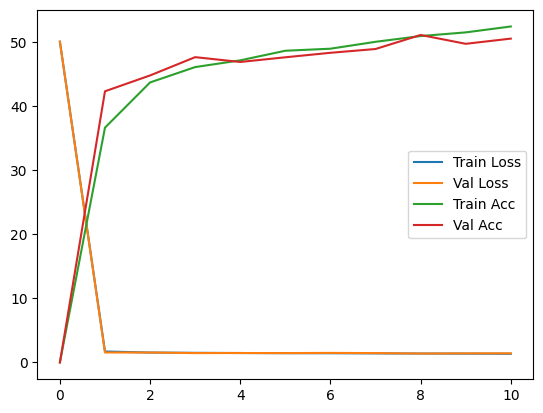

In [12]:
plt.plot(training_loss, label='Train Loss')
plt.plot(validation_loss,label='Val Loss')
plt.plot(training_accuracy, label='Train Acc')
plt.plot(validation_accuracy,label='Val Acc')
plt.legend()
plt.show

##Testing the trained network

In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
model.eval()
val_loss = 0
correct_val = 0
total_val = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images.to(device))
        loss = loss_func(outputs, labels.to(device))
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        for label, prediction in zip(labels, predicted.cpu()):
          if label == prediction:
              correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'No predictions for class: {classname:5s}')



Accuracy for class: plane is 58.1 %
Accuracy for class: car   is 65.5 %
Accuracy for class: bird  is 36.0 %
Accuracy for class: cat   is 27.2 %
Accuracy for class: deer  is 39.5 %
Accuracy for class: dog   is 35.6 %
Accuracy for class: frog  is 55.5 %
Accuracy for class: horse is 59.8 %
Accuracy for class: ship  is 60.4 %
Accuracy for class: truck is 67.2 %


## It's always good to implement a DL-based technique yourself :), but if you're short on time, there are already trained models online.

In [ ]:
import torchvision.models as models